In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500
...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083


In [7]:
twitter_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "twitter"]

In [8]:
twitter_price

,financeType,date,open,high,low,close,adjustedClose,volume
3030,twitter,2013-11-07,45.099998,50.090000,44.000000,44.900002,44.900002,117701600
3031,twitter,2013-11-08,45.930000,46.939999,40.689999,41.650002,41.650002,27925300
3032,twitter,2013-11-11,40.500000,43.000000,39.400002,42.900002,42.900002,16113900
3033,twitter,2013-11-12,43.660000,43.779999,41.830002,41.900002,41.900002,6316700
3034,twitter,2013-11-13,41.029999,42.869999,40.759998,42.599998,42.599998,8688300
...,...,...,...,...,...,...,...,...
5208,twitter,2022-07-06,38.209999,38.450001,37.740002,38.209999,38.209999,4870300
5209,twitter,2022-07-07,38.320000,39.509998,38.320000,38.790001,38.790001,13214900
5210,twitter,2022-07-08,37.509998,37.549999,36.799999,36.810001,36.810001,26156700
5211,twitter,2022-07-11,34.599998,34.900002,32.549999,32.650002,32.650002,67071300


In [9]:
end_date = twitter_price['date'].iloc[-1]
end_date

'2022-07-12'

In [10]:
twitter_price['date'] = pd.to_datetime(twitter_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
twitter_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
dtype: object

In [12]:
twitter_price.set_index("date",inplace = True)

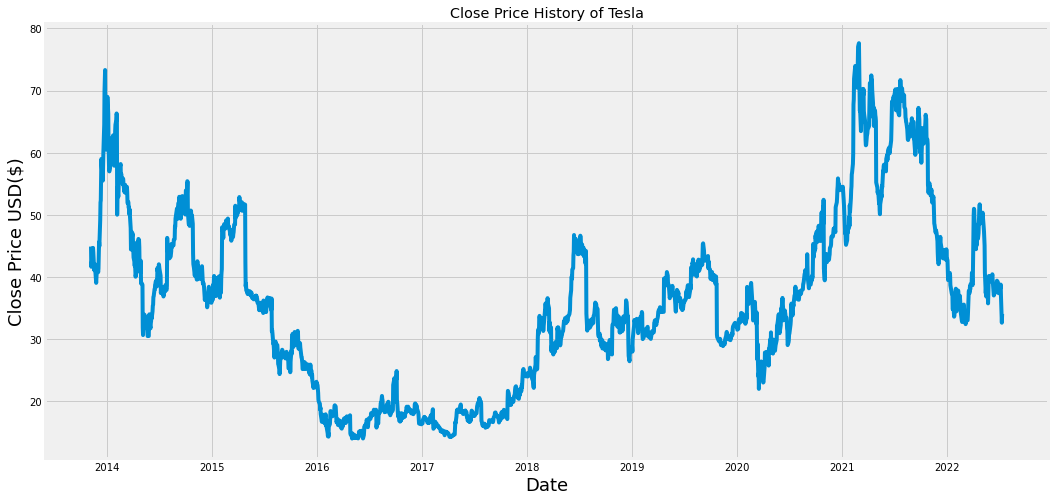

In [13]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Tesla')
plt.plot(twitter_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [14]:
data = twitter_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2013-11-07,44.900002
2013-11-08,41.650002
2013-11-11,42.900002
2013-11-12,41.900002
2013-11-13,42.599998


In [15]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [16]:
train, test = train_test_split(data, test_size=0.2)

In [17]:
train.shape, test.shape

((1747, 1), (436, 1))

In [18]:
train

,close
date,
2013-11-07,44.900002
2013-11-08,41.650002
2013-11-11,42.900002
2013-11-12,41.900002
2013-11-13,42.599998
...,...
2020-10-09,45.900002
2020-10-12,48.250000
2020-10-13,47.000000


In [19]:
test

,close
date,
2020-10-16,45.810001
2020-10-19,45.820000
2020-10-20,46.349998
2020-10-21,50.240002
2020-10-22,50.279999
...,...
2022-07-06,38.209999
2022-07-07,38.790001
2022-07-08,36.810001


In [20]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.3583779 ],
       [0.29298967],
       [0.3151525 ]])

In [21]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(1746, 1747)

In [22]:
train_scaled.shape,test_scaled.shape

((1747, 1), (436, 1))

In [23]:
train_scaled

array([[0.48553919],
       [0.43445463],
       [0.45410254],
       ...,
       [0.51854765],
       [0.50251496],
       [0.50330086]])

In [24]:
test_scaled

array([[0.49984286],
       [0.50000002],
       [0.50833071],
       [0.56947507],
       [0.57010375],
       [0.57261868],
       [0.54998431],
       [0.58566491],
       [0.54259668],
       [0.60389817],
       [0.4298963 ],
       [0.40018865],
       [0.43571206],
       [0.45190191],
       [0.46683434],
       [0.45756052],
       [0.4586608 ],
       [0.44640052],
       [0.4655769 ],
       [0.45268787],
       [0.46321914],
       [0.45143039],
       [0.45331656],
       [0.46086142],
       [0.46541969],
       [0.48208113],
       [0.48616788],
       [0.49072621],
       [0.5095882 ],
       [0.51210314],
       [0.51084564],
       [0.51336057],
       [0.52216287],
       [0.53096515],
       [0.53002203],
       [0.53269418],
       [0.52530653],
       [0.52216287],
       [0.5847218 ],
       [0.58833701],
       [0.59745366],
       [0.61002832],
       [0.62904748],
       [0.63847851],
       [0.65796921],
       [0.63863566],
       [0.64287963],
       [0.633

In [25]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [27]:
print(X_train.shape), print(y_train.shape)

(1646, 100)
(1646,)


(None, None)

In [28]:
print(X_test.shape), print(ytest.shape)

(335, 100)
(335,)


(None, None)

In [29]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [30]:
print(X_train.shape), print(y_train.shape)

(1646, 100, 1)
(1646,)


(None, None)

In [31]:
print(X_test.shape), print(ytest.shape)

(335, 100, 1)
(335,)


(None, None)

In [32]:
X_test

array([[[0.49984286],
        [0.50000002],
        [0.50833071],
        ...,
        [0.8410877 ],
        [0.79880548],
        [0.85586296]],

       [[0.50000002],
        [0.50833071],
        [0.56947507],
        ...,
        [0.79880548],
        [0.85586296],
        [0.85020435]],

       [[0.50833071],
        [0.56947507],
        [0.57010375],
        ...,
        [0.85586296],
        [0.85020435],
        [0.88447032]],

       ...,

       [[0.36262187],
        [0.34313111],
        [0.34077334],
        ...,
        [0.38069791],
        [0.38305568],
        [0.38038353]],

       [[0.34313111],
        [0.34077334],
        [0.36105   ],
        ...,
        [0.38305568],
        [0.38038353],
        [0.38950019]],

       [[0.34077334],
        [0.36105   ],
        [0.34941847],
        ...,
        [0.38038353],
        [0.38950019],
        [0.3583779 ]]])

In [33]:
ytest

array([0.85020435, 0.88447032, 0.86828046, 0.88321282, 0.8285131 ,
       0.82081115, 0.80477839, 0.79000313, 0.75526569, 0.74174793,
       0.74269098, 0.76909779, 0.76988375, 0.77994347, 0.78308715,
       0.7895316 , 0.83291422, 0.86419366, 0.89924558, 0.89877404,
       0.89358698, 0.91857906, 0.87598241, 0.90694753, 0.88195545,
       0.84768948, 0.81248034, 0.8381013 , 0.79063188, 0.83322854,
       0.8285131 , 0.8173531 , 0.81248034, 0.80289215, 0.64775233,
       0.63769261, 0.63486331, 0.6216599 , 0.62558948, 0.62527512,
       0.59415283, 0.61097144, 0.57670548, 0.56743167, 0.59289534,
       0.60657026, 0.61584409, 0.61160012, 0.63973595, 0.63564921,
       0.67667405, 0.67573093, 0.68909148, 0.69270676, 0.69144926,
       0.68264698, 0.67824587, 0.67588809, 0.70716759, 0.71707015,
       0.70418112, 0.71832759, 0.7276014 , 0.73074508, 0.73593216,
       0.72650113, 0.72178564, 0.73404592, 0.73624647, 0.75369383,
       0.78230118, 0.82489784, 0.85256213, 0.84753226, 0.85319

In [34]:
np.random.seed(42)
window_len = 100
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [35]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [36]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [37]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
52/52 [==============================] - 13s 105ms/step - loss: 0.0076
Epoch 2/100
52/52 [==============================] - 6s 106ms/step - loss: 0.0020
Epoch 3/100
52/52 [==============================] - 5s 105ms/step - loss: 0.0017
Epoch 4/100
52/52 [==============================] - 6s 113ms/step - loss: 0.0016
Epoch 5/100
52/52 [==============================] - 6s 114ms/step - loss: 0.0014
Epoch 6/100
52/52 [==============================] - 6s 120ms/step - loss: 0.0012
Epoch 7/100
52/52 [==============================] - 6s 115ms/step - loss: 0.0012
Epoch 8/100
52/52 [==============================] - 6s 117ms/step - loss: 0.0011
Epoch 9/100
52/52 [==============================] - 6s 116ms/step - loss: 9.7458e-04
Epoch 10/100
52/52 [==============================] - 6s 114ms/step - loss: 9.1618e-04
Epoch 11/100
52/52 [==============================] - 6s 116ms/step - loss: 7.7788e-04
Epoch 12/100
52/52 [==============================] - 6s 115ms/step - loss: 7.4252e

52/52 [==============================] - 6s 118ms/step - loss: 2.9915e-04
Epoch 96/100
52/52 [==============================] - 6s 117ms/step - loss: 3.0927e-04
Epoch 97/100
52/52 [==============================] - 6s 113ms/step - loss: 3.0993e-04
Epoch 98/100
52/52 [==============================] - 6s 118ms/step - loss: 3.2789e-04
Epoch 99/100
52/52 [==============================] - 6s 108ms/step - loss: 2.9394e-04
Epoch 100/100
52/52 [==============================] - 6s 109ms/step - loss: 3.4737e-04


In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 39ms/step


In [39]:
test_predict

array([[0.83312654],
       [0.7774976 ],
       [0.8453632 ],
       [0.7966643 ],
       [0.83822435],
       [0.7547996 ],
       [0.783213  ],
       [0.745995  ],
       [0.74361724],
       [0.7021402 ],
       [0.70085347],
       [0.69859076],
       [0.7286113 ],
       [0.7192763 ],
       [0.73713577],
       [0.73435944],
       [0.7442061 ],
       [0.7905958 ],
       [0.80978495],
       [0.84706354],
       [0.8349953 ],
       [0.8386372 ],
       [0.86536163],
       [0.8051959 ],
       [0.8693366 ],
       [0.8081599 ],
       [0.79928803],
       [0.7582472 ],
       [0.8002441 ],
       [0.7245373 ],
       [0.80568826],
       [0.7629466 ],
       [0.77213013],
       [0.76124656],
       [0.7534269 ],
       [0.5742593 ],
       [0.62717587],
       [0.58991444],
       [0.5864398 ],
       [0.59146535],
       [0.58955455],
       [0.55574864],
       [0.5834806 ],
       [0.5364112 ],
       [0.5391363 ],
       [0.5651483 ],
       [0.5752665 ],
       [0.585

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
test_predict

array([[67.013504],
       [63.474392],
       [67.79201 ],
       [64.69379 ],
       [67.33784 ],
       [62.03035 ],
       [63.83801 ],
       [61.4702  ],
       [61.318924],
       [58.680157],
       [58.598293],
       [58.45434 ],
       [60.364246],
       [59.770355],
       [60.906574],
       [60.729946],
       [61.356388],
       [64.30771 ],
       [65.52852 ],
       [67.90018 ],
       [67.1324  ],
       [67.3641  ],
       [69.06431 ],
       [65.236565],
       [69.31719 ],
       [65.42513 ],
       [64.8607  ],
       [62.249683],
       [64.921524],
       [60.10506 ],
       [65.26788 ],
       [62.54866 ],
       [63.132915],
       [62.440502],
       [61.943016],
       [50.544373],
       [53.910927],
       [51.540356],
       [51.319298],
       [51.639023],
       [51.51746 ],
       [49.366726],
       [51.131035],
       [48.13648 ],
       [48.30985 ],
       [49.964733],
       [50.60845 ],
       [51.287785],
       [50.932095],
       [53.116943],


In [42]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

31.13674159928873

In [43]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

51.05121881119293

In [44]:
test_predict.shape

(335, 1)

In [45]:
targets = test[price_column][window_len+1:]
targets

date
2021-03-15    70.279999
2021-03-16    69.250000
2021-03-17    70.199997
2021-03-18    66.720001
2021-03-19    66.230003
                ...    
2022-07-06    38.209999
2022-07-07    38.790001
2022-07-08    36.810001
2022-07-11    32.650002
2022-07-12    34.060001
Name: close, Length: 335, dtype: float64

In [46]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2021-03-15    67.013504
2021-03-16    63.474392
2021-03-17    67.792007
2021-03-18    64.693787
2021-03-19    67.337837
                ...    
2022-07-06    37.675568
2022-07-07    37.877216
2022-07-08    37.713188
2022-07-11    38.277706
2022-07-12    36.328571
Length: 335, dtype: float32

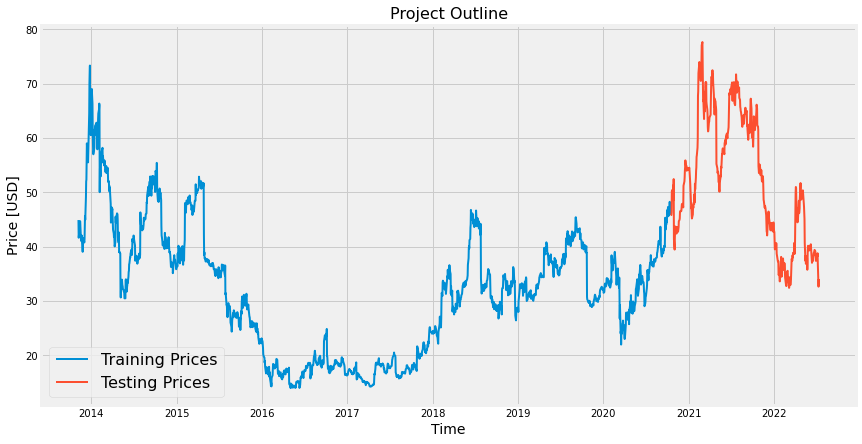

In [47]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

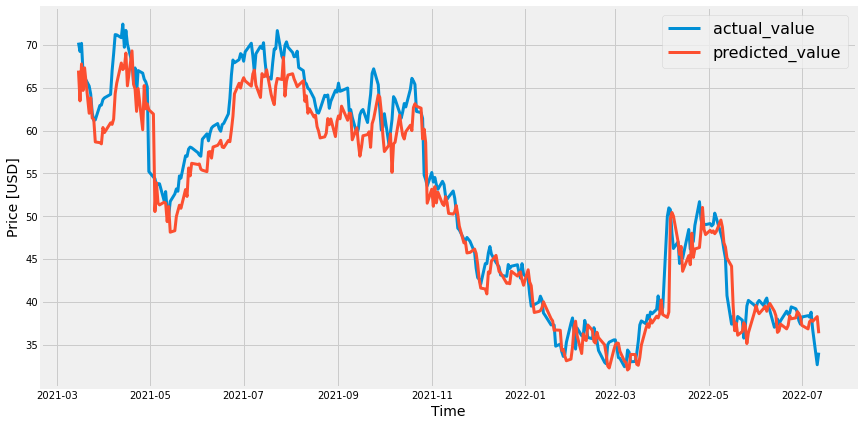

In [48]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [49]:
len(test)

436

In [50]:
length = len(test_scaled)
length

436

In [51]:
#Getting the last 100 days records
fut_inp = test_scaled[length-100:]
fut_inp.shape

(100, 1)

In [52]:
fut_inp = fut_inp.reshape(1,-1)

In [53]:
fut_inp.shape

(1, 100)

In [54]:
fut_inp

array([[0.34941847, 0.33668659, 0.31923925, 0.29739077, 0.29471862,
        0.32961334, 0.33448604, 0.33857278, 0.33872999, 0.32395473,
        0.30619307, 0.30462119, 0.28937439, 0.29346119, 0.32002515,
        0.31609557, 0.29849105, 0.29896259, 0.31373785, 0.33574348,
        0.36607985, 0.37346748, 0.36828042, 0.38384158, 0.3770827 ,
        0.38997173, 0.38651366, 0.39468721, 0.41936498, 0.39280102,
        0.38792833, 0.39767372, 0.5652311 , 0.5811066 , 0.57780575,
        0.53473751, 0.50644454, 0.5187048 , 0.47893746, 0.50047154,
        0.48836849, 0.54133924, 0.50534426, 0.51414653, 0.51980515,
        0.54888402, 0.59242381, 0.56067277, 0.54432569, 0.55171334,
        0.55029867, 0.55218486, 0.54794091, 0.55092742, 0.57136125,
        0.56255895, 0.53363723, 0.52263438, 0.50424397, 0.48836849,
        0.41983656, 0.3674945 , 0.38211256, 0.35900659, 0.3659227 ,
        0.38164103, 0.37488215, 0.34187361, 0.3638793 , 0.40097456,
        0.41119144, 0.40223199, 0.39751651, 0.40

In [55]:
tmp_inp = list(fut_inp)

In [56]:
tmp_inp

[array([0.34941847, 0.33668659, 0.31923925, 0.29739077, 0.29471862,
        0.32961334, 0.33448604, 0.33857278, 0.33872999, 0.32395473,
        0.30619307, 0.30462119, 0.28937439, 0.29346119, 0.32002515,
        0.31609557, 0.29849105, 0.29896259, 0.31373785, 0.33574348,
        0.36607985, 0.37346748, 0.36828042, 0.38384158, 0.3770827 ,
        0.38997173, 0.38651366, 0.39468721, 0.41936498, 0.39280102,
        0.38792833, 0.39767372, 0.5652311 , 0.5811066 , 0.57780575,
        0.53473751, 0.50644454, 0.5187048 , 0.47893746, 0.50047154,
        0.48836849, 0.54133924, 0.50534426, 0.51414653, 0.51980515,
        0.54888402, 0.59242381, 0.56067277, 0.54432569, 0.55171334,
        0.55029867, 0.55218486, 0.54794091, 0.55092742, 0.57136125,
        0.56255895, 0.53363723, 0.52263438, 0.50424397, 0.48836849,
        0.41983656, 0.3674945 , 0.38211256, 0.35900659, 0.3659227 ,
        0.38164103, 0.37488215, 0.34187361, 0.3638793 , 0.40097456,
        0.41119144, 0.40223199, 0.39751651, 0.40

In [57]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [58]:
tmp_inp

[0.34941846979338886,
 0.33668659242470567,
 0.3192392479993357,
 0.29739077164684546,
 0.29471862439729446,
 0.3296133446846907,
 0.33448604217947375,
 0.3385727761037146,
 0.33872999082348265,
 0.32395473077435066,
 0.30619306693774273,
 0.30462118695164353,
 0.28937439277150534,
 0.2934611895690594,
 0.3200251486965646,
 0.3160955666187786,
 0.2984910546286256,
 0.29896258875963155,
 0.31373784880876365,
 0.3357434770077087,
 0.3660798506482167,
 0.3734674806727828,
 0.3682804166117769,
 0.38384157735813773,
 0.37708269618434587,
 0.389971725399484,
 0.3865136617343756,
 0.39468720817449887,
 0.419364983622995,
 0.3928010244954899,
 0.3879283270007069,
 0.39767372199027284,
 0.5652311017870686,
 0.5811065976629957,
 0.5778057487176554,
 0.5347375134267923,
 0.5064445381850614,
 0.5187048028310972,
 0.4789374636405592,
 0.5004715419901701,
 0.4883684920639024,
 0.5413392427541296,
 0.5053442552032813,
 0.5141465347758504,
 0.5198051486861905,
 0.5488840246251504,
 0.5924238097653477,

In [59]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.3044261932373047], [0.2978380024433136], [0.2914102077484131], [0.2853742241859436], [0.2794145345687866], [0.2734748423099518], [0.2675590217113495], [0.2616976201534271], [0.2559276223182678], [0.2502802908420563], [0.2447759360074997], [0.23942312598228455], [0.23422065377235413], [0.22916075587272644], [0.2242317944765091], [0.21942079067230225], [0.21471521258354187], [0.2101040631532669], [0.20557810366153717], [0.20113013684749603], [0.19675463438034058], [0.1924474686384201], [0.18820545077323914], [0.18402612209320068], [0.17990747094154358], [0.17584751546382904], [0.17184457182884216], [0.1678968369960785], [0.16400255262851715], [0.16015984117984772]]


In [60]:
end_date

'2022-07-12'

In [61]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/12/2022'

In [62]:
preds = scaler.inverse_transform(lst_output)
preds

array([[33.3775935 ],
       [32.95845282],
       [32.54951654],
       [32.16550729],
       [31.78635185],
       [31.40846865],
       [31.03210416],
       [30.65920181],
       [30.29211456],
       [29.93283135],
       [29.58264431],
       [29.24209856],
       [28.91111729],
       [28.5892066 ],
       [28.27562609],
       [27.96955004],
       [27.67018118],
       [27.37681987],
       [27.08887834],
       [26.8058987 ],
       [26.52752925],
       [26.25350738],
       [25.98363021],
       [25.71774134],
       [25.45571276],
       [25.19741841],
       [24.94275114],
       [24.69159627],
       [24.44384191],
       [24.19936862]])

In [63]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/22/2022'

In [64]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15',
               '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21',
               '2022-07-22', '2022-07-25', '2022-07-26', '2022-07-27',
               '2022-07-28', '2022-07-29', '2022-08-01', '2022-08-02',
               '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-08',
               '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
               '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18',
               '2022-08-19', '2022-08-22'],
              dtype='datetime64[ns]', freq='B')

In [65]:
len(c)

30

In [66]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-12    33.377594
2022-07-13    32.958453
2022-07-14    32.549517
2022-07-15    32.165507
2022-07-18    31.786352
2022-07-19    31.408469
2022-07-20    31.032104
2022-07-21    30.659202
2022-07-22    30.292115
2022-07-25    29.932831
2022-07-26    29.582644
2022-07-27    29.242099
2022-07-28    28.911117
2022-07-29    28.589207
2022-08-01    28.275626
2022-08-02    27.969550
2022-08-03    27.670181
2022-08-04    27.376820
2022-08-05    27.088878
2022-08-08    26.805899
2022-08-09    26.527529
2022-08-10    26.253507
2022-08-11    25.983630
2022-08-12    25.717741
2022-08-15    25.455713
2022-08-16    25.197418
2022-08-17    24.942751
2022-08-18    24.691596
2022-08-19    24.443842
2022-08-22    24.199369
Freq: B, dtype: float64

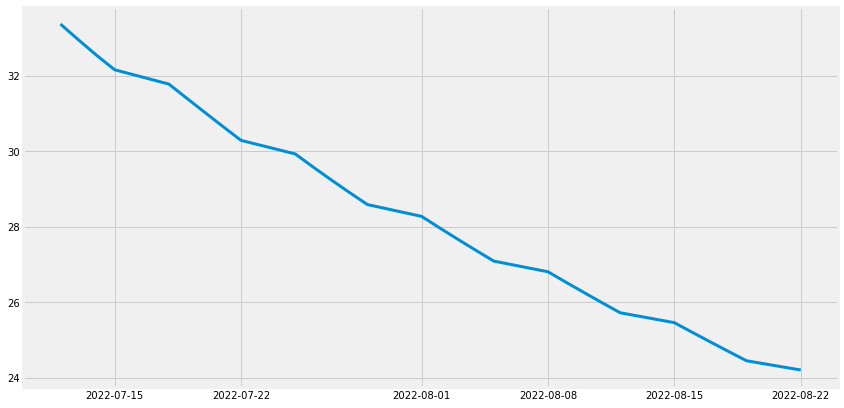

In [67]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

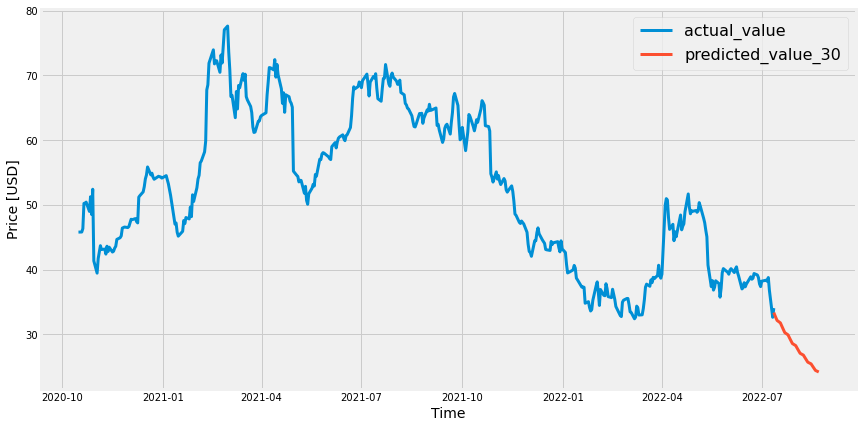

In [68]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)